In [11]:
from google.colab import files 

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle 

In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

In [18]:
! kaggle datasets download moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip fruits.zip

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader


In [21]:
path = '/content/fruits-360_dataset/fruits-360'
print('Folders :', os.listdir(path))
classes = os.listdir(path + "/Training")
print('131 classes :', classes)

Folders : ['test-multiple_fruits', 'readme.md', 'Training', 'Test', 'LICENSE', 'papers']
131 classes : ['Rambutan', 'Fig', 'Quince', 'Redcurrant', 'Apple Golden 1', 'Pineapple Mini', 'Walnut', 'Peach', 'Apple Red 1', 'Pomelo Sweetie', 'Potato Red', 'Tomato 4', 'Pear Kaiser', 'Avocado ripe', 'Pear Red', 'Raspberry', 'Kiwi', 'Tomato 3', 'Chestnut', 'Cherry 2', 'Pear Williams', 'Eggplant', 'Corn Husk', 'Salak', 'Grape White 3', 'Banana', 'Apple Braeburn', 'Strawberry', 'Dates', 'Tomato 2', 'Cherry Wax Yellow', 'Pear Monster', 'Apple Red Yellow 1', 'Banana Lady Finger', 'Lemon Meyer', 'Clementine', 'Cantaloupe 1', 'Corn', 'Onion Red Peeled', 'Papaya', 'Pepper Orange', 'Cherry 1', 'Apple Red Yellow 2', 'Blueberry', 'Plum 3', 'Pepper Green', 'Strawberry Wedge', 'Physalis', 'Kaki', 'Grape White 2', 'Tomato Maroon', 'Potato White', 'Peach 2', 'Nut Pecan', 'Grape White', 'Onion White', 'Tangelo', 'Apple Pink Lady', 'Hazelnut', 'Apple Crimson Snow', 'Kumquats', 'Ginger Root', 'Peach Flat', 'Mang

In [22]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset = ImageFolder(path + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(path + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of training dataset : 67692
Size of test dataset : 22688


In [23]:
img, label = dataset[5000]
print(img.shape)


torch.Size([3, 100, 100])


In [24]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple Red Delicious (10)


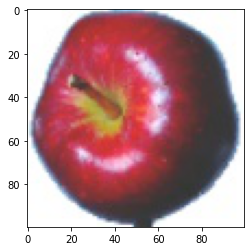

In [25]:
show_image(img, label)

In [26]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 5000
num_epochs = n_iters / (len(dataset) / batch_size)
num_epochs = int(num_epochs)

In [27]:
# data loader
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


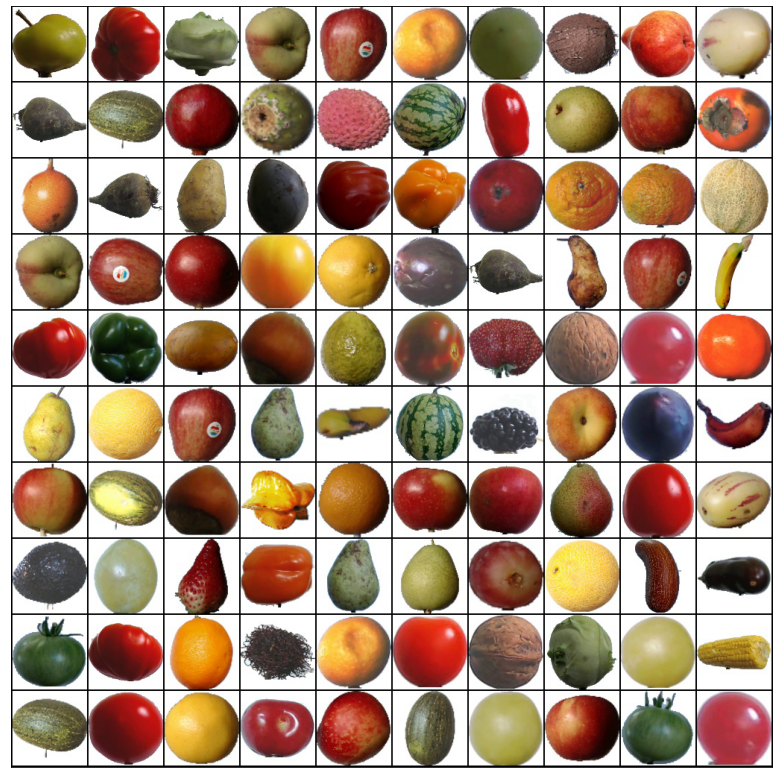

In [28]:
from torchvision.utils import make_grid
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(14,14))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
    break

In [29]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        # Linear function 1: 30000 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2 : Tanh
        self.tanh2 = nn.Tanh()
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3 ReLU
        self.relu3 = nn.ELU()
        # Linear function 4 (readout): 150 --> ?????????
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.relu3(out)
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

In [30]:
# instantiate ANN
input_dim = 3*100*100
#hidden layer dim is one of the hyper parameter and it should be chosen and tuned.
hidden_dim = 150
output_dim = 131
# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)
# Cross Entropy Loss
error = nn.CrossEntropyLoss()
# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [31]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, 3*100*100))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs,labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0

            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 3*100*100))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 500  Loss: 3.0890517234802246  Accuracy: 19.69322967529297 %
Iteration: 1000  Loss: 2.2362678050994873  Accuracy: 29.804302215576172 %
Iteration: 1500  Loss: 1.748457908630371  Accuracy: 51.30465316772461 %
Iteration: 2000  Loss: 0.9737021923065186  Accuracy: 66.21121215820312 %
Iteration: 2500  Loss: 0.6413146257400513  Accuracy: 73.73941802978516 %
Iteration: 3000  Loss: 0.42632797360420227  Accuracy: 78.33216094970703 %
Iteration: 3500  Loss: 0.2472527176141739  Accuracy: 82.38275909423828 %


KeyboardInterrupt: ignored

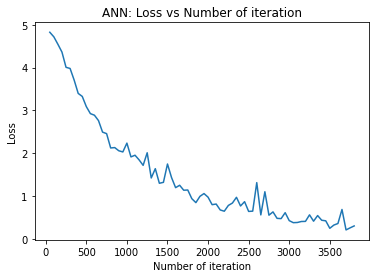

In [32]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

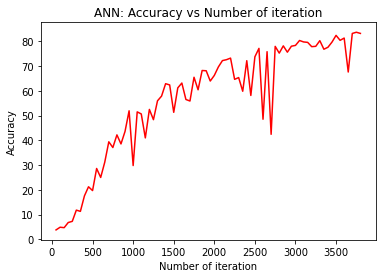

In [33]:
# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()